# Basic setup

## Imports

In [2]:
# Libraries 
import sqlite3
import pandas as pd 
import numpy as np 
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn import linear_model
from urllib.request import urlopen
from google.colab import files
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy.special import expit
import spacy
!python -m spacy download en_core_web_lg
from sklearn.metrics import classification_report, confusion_matrix


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Prepare the dataframe

In [3]:
# import the SQL into a dataframe

# https://datacarpentry.org/python-ecology-lesson/09-working-with-sql/index.html

con = sqlite3.connect("/content/auth.db")

# Load the data into a DataFrame
data_db = pd.read_sql_query("SELECT * from user", con)

# Select only data for 2002
df = data_db[data_db.responseCounter == 6]

# Write the new DataFrame to a new SQLite table
# surveys2002.to_sql("surveys2002", con, if_exists="replace")

con.close()

In [4]:
# drop the unnecessary columns
df = df[["key","response4", "response5"]]

In [5]:
# sum the responses


def calc(value):
  k = 0
  null_r = list("100010100010100") # null response -- no depression
  value = list(value)
  for i in range(len(value)):
    if value[i] != null_r[i]:
      k+=1
  return k


df["response5"] = df[["response5"]].applymap(lambda x: sum([int(i) for i in x]) )
df["response4"] = df[["response4"]].applymap(lambda x: calc(x) )


In [6]:
df

,key,response4,response5
8,f0716a15f69feb3963e6e900fbad2da2,10,0
25,5d543923e019079fe8de5b20525003c3,5,5
37,68554f776ebde65d3d17a22c3c00dea0,2,5
48,df93ea050cbf78715c85b7e817433319,0,0
50,9836aab0214b52db88a687750fdeded9,0,0
...,...,...,...
926,3eafc533cfe8681172033c0855c66011,5,8
927,568b3801ef78dc040a60981c7e415752,7,3
929,e30ce4fc4a39f8bb83cd39c0d6e6067c,10,11
931,14006dfae7c4e65a514c06fd19b544e7,0,0


In [7]:
df[['response4', 'response5']].corr(method="pearson")

,response4,response5
response4,1.000000,0.731861
response5,0.731861,1.000000


## Aggregate the text responses on the dataframe


In [8]:
transcribed_text = {'9836aab0214b52db88a687750fdeded9': "Yeah, I think there's a beach, uh there are a lot of people around, I can see signs and symbols. We've got people surfing around, we've got, uh, sun [inaudible 00:00:13], uh people in the dirt, uh just like people in general, there's a lot of people, like they are in the pool or in car with a [inaudible 00:00:32]. Other stuff going on there cause [inaudible 00:00:35]", 'b095bfe472c476e302a21765e5831855': "There are a bunch of people and creatures out enjoying the beach. They're enjoying the nice weather, they're all look like they're in great moods. Even the sun is smiling. And there's a lot of people there, though. It's very crowded at the beach today.", '297687b8a852aeb877479101a8e6a8a1': "This is a very interesting picture of a beach scene. It has a lot of people both in the water and on the beach, as well as animals. People are in different physical positions, and, uh, there're also modes of transportation in the picture. The sun is shining brightly in the sky and has sunglasses on.", 'b89e6087aa01698723fec3d86f87f8ff': "The image is an image of a beach. There're a lot of people on the beach. There are a lot of animals on the beach. The sun is out. It seems that everybody is having fun. ", '0649ed6a8722061b3090095af3409f5a': "The image below is showing a scene at the beach. Um, quite wacky scene. Um, a lot of people. There's a car that's driving in the water, there's a boat that's sailing upside down. There's [inaudible 00:00:14] using a big ruler as a surfboard. There's a sun in the sky with sunglasses on. And then, um, there is a stoplight that is in the, um, sun also for some reason.", 'fde1ea5bbc99efbae2e60e2306ce0ab3': "This is a very fun, sunny, beach day. Everyone is having fun and, despite the craziness of the entire situation, everyone seems to be minding their own business and not questioning the impossibility of some of these events happening around them. I'm seeing everyone is just, um, carefree, pretty much enjoying their life and enjoying seeing everyone else enjoying their lives. ", 'baf1e55795b2d1c9888a0856952034a4': 'So, this looks like a really fun place, it looks like everyone is happy and having a good time. I think that the atmosphere just makes it look like a really fun and chilled place to be.', '78629d7eb715ec0245b62fd61157e51e': 'The scene being shown in the image is that of people enjoying themselves at the beach. It seems to be a sunny day. People on the beach seem to be very happy and pleasant and there is a very positive emotion coming out of the image. For some weird reason there is a traffic light in the middle of the beach. It also seems to be a very nice weather for people to enjoy themselves. Some people seem to be building sandcastles. There are some people who are surfing and some people are simply working out and having a great time.', 'ae521617ed4e8a05fbd86af9c25e7e8b': "Looks like it's a fun day at the beach. Everyone is outside, having a good time. People are smiling, they're exercising. Even the animals are in on it. Looks like a great, positive beach day. ", '92f38c5dc6e0d4b0659317e46d8203d4': "In this picture, it looks like there's a bunch of people having fun. They're all at the beach, entertaining themselves in some type of way. There are even animals in the pictures with the people, who seem to be interacting together, also. I see animals playing instruments, and it just looks like a cool, fun, summer-time day. I would love to go and be a part of this period, yeah.", '08024970a3342cc3014f7c5ee2aae021': "Y- yeah, the way I'm seeing this image, I could see people having fun on a beach. So this image describe, um, or portray a, a happy mood, portray a fun [inaudible 00:00:17] life of people having fun in a beach. They were enjoying themself, they were having a nice time, they were really having good time at the beach.", '6822f39bfb72374a0a6645a937da89ed': "Okay. This is an image of many things. It seems like it's pretty crazy and hectic. So first off, we're at a beach. Um, there's people here plus animals enjoying the beach. There's (laughing) many different animals actually such as cows, seagulls, um, fish, you know, everything, and it looks like they're all getting along with the humans. Um, it's really crowded and there's a lot going on. Like some things don't make sense like the stoplight, or the cow just swimming, or the guy upside down on the boat. Uh, it seems like a nice and bright sunny day though so everyone's enjoying their time and having a good day at the beach. There's a lot of colors going on, and yeah, like I said, it's just a little bit confusing, but it's funny at the same time. I think this is what the beach would look like if humans and animals got along like this.", 'c546449fb46fb7211f533cab219971a5': "Looks like a busy day at the beach. The mood is pretty positive. Everybody has a smiling or positive expression on their face. It looks like people are having fun. Many are probably excited based on what they're doing. You have people that are surfing, they're driving their car through the water. They're swimming. You know, they're sun-bathing, they're checking out the scene. Overall, it looks like a very positive scene. And the people look pretty happy to be there. ", '9bf4e1bd7523d8c3a28f06b12e21a313': "So this looks like a funny joke of a beach day where you have your silly little... [inaudible 00:00:14] put in there with cows swimming in the ocean, a boat upside down, you have somebody eating an ice cream upside down. So it looks like a beach day, but thrown in a bunch of funny... A bunch of funny icons where you have somebody instead of on a surf board, they're on a ruler. You have a stop and go light in the middle of the sand. Instead of somebody wearing skis, they're wearing snow shoes. So it just looks like a really silly picture.", '919d34518ab28e384a48953e646fad0c': "This is an image of people and animals on a beach. Um, it, everybody seems to be happy, having a good time out in the sun. There are people playing in the sand, there is a skate boarder, a bicyclist, a cow in the ocean (laughs), a fish playing a musical instrument, the sun is up in the corner and it is wearing sun shades. There is a man in a speed boat completely upside down. Um, one of the legs of where the lifeguard is sitting, the stand is actually a fork into the ground. And there is a crab on stilts. Many things going on. There is a traffic light embedded in the sand. There are birds, there is a bird on a car which is on top of the water in the ocean. There is a dog about to get into the water with his little inner-tube so he doesn't drown. And it just looks like everyone's having a grand old time on the beach out in the sun. ", '36c3044fe5f8ef562459ff89201976c2': "People are hanging out at the beach. There is a lifeguard, a puppy, a lady, kids, and lots of other things. There are people riding bikes, skateboards, on the deck, and there's people building sand castles. There's a sun with sunglasses in the sky. There's a bird on top of a green car in the ocean while a guy surfs on a ruler. There's a cow swimming, too. There's a guy who looks like he's scuba diving, and it looks like there's a granny watching an little kid down. There's a fish playing the trumpet to a guy who looks concerned. And there's a stop light in the sand while a crab is on stilts.", 'e985acb27d4647a43a0ae685fbce9364': 'Everyone is happy in this picture. I see various things swimming in the ocean, I see a lot of people on the sand, I see a lot of activities taking place like driving a car in the ocean, a fish playing the horn, a guy, uh, surfing on a ruler, someone is snorkeling, a cow is swimming, a lifeguard has tennis rackets on the bottom of his shoe. I see a lot of birds that are looking for food and I see a bicycler and a skateboarder.', 'b77f0c90fbbba8212ae4a31e8229da8d': 'It is a warm and sunny day on the beach. There is a variety of people, animals, and things taking place on the beach. The sun is overseeing everyone, wearing glasses and being cool. In the water, there is a car surfing, a cow swimming, and a fish playing the trumpet, among other things. On the beach, a lifeguard looks over the people in the water, while various people and activities are taking place behind him. On the boardwalk behind the beach, a man is b... on his bicycle and a kid is skateboarding.', 'f9476d838fd0d0d65754580caa140f9e': "Okay, so, time to analyze the mood. This is a very happy mood. Everybody is at the beach, having a good time. The sun is out. Um, there's people surfing. There's people sailing, although the sailboat is upside-down, but he's still having a good time. There's a cow in the water. There's people on the beach. Um, everybody seems to be very happy to be there. Um, and, uh, um, the only person that doesn't seem to be happy is the person that's in the water that has a fish blowing a trumpet in his ear. So, um, but everything else is just happy to be at the beach. The mood is good. Everybody's having a great time.", '8a6a69407ab688bf3750a442e18be741': "In this scene, I see the ocean and the beach. There is a lifeguard on duty, a person surfing. There's a sailboat that's sailing upside down. The sun has sunglasses on. There's a green car with a duck in the water. It's a very busy scene with lots to look at.", '9e4a8c212b19428b1b54806d2550d75c': "This looks like a fun day at the beach. Um, there's some crazy things going on, but people seem to be having fun, as well as there's animals having fun. Everyone seems to be very busy. And even the crazy things going in, looks like everyone is enjoying themselves.", '509413c3e4589280c57f286625c61028': "So I'm looking at a picture of happy people. There's happy people, there's animals that look happy, everyone's smiling, you know, it's a day at the beach. Got car driving on the water, upside-down sail boat, you know, there's a red bird flying, people with umbrellas, skateboarders, you know, it's all very nice. The sun has some sunglasses on, it's a very nice day. And as you could say, it's a very happy day, people really en- are enjoying how nice it is.", 'eed40a3fe8b9de43143be65eb8f1d460': "In this image, it looks like, um, a beach. Then, uh, some people in, uh, this beach. Some... I can see an animal in the... Swimming in the water. A buffalo. And I see a yacht, and then, uh, I see a car, riding in the... riding in the beach. And then a bird is on the green car. And I see some people sitting down on the seashore. Then a traffic indicator, was on the beach sand. And I see some people also swimming in the beach. And then on the other side, just close to the beach, see people walking on the sand. I see a pigeon and, uh, I see... I see person riding a bicycle, on the other way. And I see somebody on a skateboard, wearing a yellow cloth. And somebody having a big umbrella. They're standing beside a dock. I see... I see, uh, somebody, uh, wearing a pink. And it's sunny, on a bright day. And I see somebody floating, riding a measuring tape, like a ruler, right across the beach. And I see another red bird, flying around the beach.", '4e52fb84c52a3da810dca86a8c0c4ea1': "I feel like the mood of this photo is really energetic, upbeat, and really fun. There's a lot going on, it's a busy day at the beach and there are things to do at every corner. There are also a lot unusual things, like you'll look into the ocean and see someone driving in the ocean, someone is using a ruler as a surfboard, it's just a lot of wacky, silly things going on, but a lot of fun to watch. The lifeguard is wearing rackets on his feet. There's a dog about to go swimming with raft around. And for some reason there is a traffic light in the middle of the sand, but overall it seems like people are having a lot of fun.  ", '40e5423cec3fdf73af9a9012b82aa73a': "This looks like it's a really happy, exciting picture. Um, it seems like everyone is at the beach on a really sunny, bright day. Uh, I see a lot of people and some animals (laughs) playing in the ocean. Um, I see an upside down boat, and a car, a guy on top of a ruler. And I see a cow and a fish, a giant fish playing an instrument. Um, on the sand, there is a hunky lifeguard. Um, and I see a crab on stilt, and a dog. Um, and uh, a yellow and orange, um, inner tube? And um, some guy buried under the sand.And on the boardwalk or the sidewalk, um, I see some people on... one guy is on a bicycle, another guy is on a skateboard. Um, basically, I would say that, you know, this picture is very comical. There were some things here that don't make sense. I see, um, a younger person holding an ice cream cone upside down. And I think, I mentioned earlier that there is a guy in an upside down boat in the ocean. But, you know, over all it's a very jovial scene. Most people look very happy, and very excited to be outside. Um, everyone just seems like they're enjoying a vacation or of a special holiday. ", 'da55724bc02afd66cd6261466a86ee8b': 'In this image, I see um... I can see whole lot of people in there. I can see kids. I can see adults and they... they on the beach. Some of them are swimming. I can see a car onto of the water, and the sun is out. Some people are riding their bike. Some people skating.', 'd70e15beee4bfaf11d3dd9787039676b': 'This is a beach-side, with people flecked in around.Cow in the water.Divers and also people surfing, in the beach.Some, playing with the sand, burying themselves in the sand.And, also, other animals cruising around.', '2028593763c3971e46f0eb239cde5c3f': "This is a picture of a beach, and there is a lot of animals, and a lot of people. The people are sitting on the beach, one's in a chair, some people are riding bikes, some people are skateboarding, some people are carrying those big umbrellas. Some people are swimming.(laughter)[crosstalk 00:00:25] animals are in the water swimming, and there's tons of birds everywhere. And there's even a-[inaudible 00:00:32]... fork on the beach, which looks it's probably out of place. And there's a nice sun and he's wearing sunglasses-[inaudible 00:00:37]... and it's super cute.", '74353a5d6af91fe9f07b87dfc67aa572': "I am looking at a cartoon picture of a beach. There are a lot of crazy things going on here. There's a lifeguard with some snow skis on, there's a dog with a ring inflatable around about to get into the water, there's another guy in the water who is surfing on what looks like a ruler. The sun is wearing sunglasses and there's a sailboat that is upside down. There's also a green car going across the water with some sort of bird on top. ", '55f049a2b63629b62620c38788fe312b': "This picture is very busy, it is at a beach and there are many people at the beach. There are people in the water along with animals in the water, a car's driving on the water, there's a fish playing a saxophone. On the beach there are many people as well as an animal, a dog that is, has a swimming device around him. There's also a boardwalk where people are riding a skateboard and a bicycle, it's a sunny day and it is very colorful.", 'a2518667ea913d18aa14987ef4c1ef20': "This scene is a sunny day at the beach. There are people in the water, people on the beach. Somethings don't make sense though, like an upside down sailboat, and glasses on the sun, and a car on the water, and other animals that shouldn't be in the water.", '830753dfb3fc68c76554e0c8755b4fb4': "This is a beach setting. It has a lot of people out, very happy, enjoying the beach and water. There's some people in the ocean, there's some people on the sand, and there's, um, a cow in the ocean, and a dog walking around with a floatie on. And there is a crab walking around with stilts, a couple ducks, a skateboarder, a bicyclist, someone holding a upside-down ice cream cone. And I guess everyone here took some DMT", '67fb89a3b620e7afc20c2ee9d20a1c5f': "Okay, so I see sort of, like, a chaotic, um, beach scene. It's- it's, like, a cartoon beach scene. It reminds me a bit of, like, Where's Waldo books, or something like that. Um, it's, yeah, I mean, it's like a- a cartoonish beach scene with, you know, a- a sun that's got sun glasses and a smile, so, like, various personified animals are participating. There's a lot of absurd, surreal stuff going on, like a man driving a- a car on the water, or a person sailing a boat upside-down. Um, there's, like, a- a- a... yeah, lot's of absurd stuff. A crab on crutches, um, there's a boy who is carrying his ice cream cone upside-down, um, a fish playing trumpet. Um, so yeah, that's how I would describe it, as a chaotic, absurd, uh, beach scene.", '0584904644e2483b81c7eeaa491f5063': 'The sun shining bright.An upside down motorboat.A car s- speeding across the water.A sp... (inaudible) rulers, uh, surfboarding.A cow out in the water, or a bull.And a fish playing a trumpet.', '3982621765ec7071920e5a1adc27bc39': "It's the weekend, it's Sunday, and everyone is on the beach. I see a traffic light on the beach with a, uh, a red, a yellow, and a green sign. We see cows that have also come. See a whale that's blowing the trumpet and disturbing the peace, and there's someone who's looking very, uh, disappointed. In this day and age, who- it's the way animals and humans both come together and play together.", '256d7c3332ef6985bb298e2324b53242': "I feel this image is a, uh, it happened on the beach. There are people playing on the beach. There kids and, they- they- they- they... There are kids playing on the beach. There are people inside the water. There's an animal. There's a cow inside the water. People are playing, or swimming in the water. There's someone sitting on a chair by the beach. There is a woman standing by the traffic lights. There are umbrella. There's a (inaudible) in the bicycle. There is a man coming to the beach with an umbrella and a box, walking inside the beach. There is a boy, uh, skating on a skateboard. There is a white bird on the wall of the beach.", '29a707315b307658eb1ec56cd656140b': 'There is a shiny sun with, uh, sunglasses.A man is surfing with, uh, a ruler, uh, uh, surfboard.A cow is swimming, happily.Uh, there is a little green car on top of the water.Uh, there is a- a red bird flying on top of the ocean.There is uh, a dog walking.And, uh, there is a lifeguard.', 'bcef85e130a3f9f80a2adf22c66125f9': "So it looks like this is a picture on, um, a beach, and then a strange thing as there are, like, animals, like there is a cow, you know, uh, in the sea, and then there's a upside-down boat, and there's, uh, even a car driving on the sea. And there's a fish playing with a instrument, a musical instrument, and then there's a dog going walking into the, um, from the beach into the ocean, and there's a crab that's, like, looks like disabled, and, uh, in general, then, there are a lot of, like, people around the area, and there is, like, a huge fork next to a safe guard.", 'df93db34853d5c8f5aceeaa9b6c9b5f7': "This image is a cartoon illustration of a pretty wacky and unusual day at the beach. Um... There is a ton of unusual and unrealistic things happening like: a cow swimming in the ocean; um... a stop light, uh, posted in the sand; um... the lifeguard has a pair of snowshoes on; there is a guy surfing on what looks like a ruler; a car driving through the ocean... Generally, um... the illustration's like kind of wacky and fun, and um... and... and just a really good mood. It's a happy image of tons of goofy things happening. ", '2872d879b38820158bec2a6040eb1f93': "This is a scene at the beach.Everyone's very happy. Everything, even all the animals, including the sun, the people. They all have a smile on their faces. They're all enjoying themselves. They're all doing activities that they enjoy.You know, whatever, s- surfing, bicycling, um, you know, just playing with the sand. They're all enjoying themselves.There is no negative emotion shown at all. Just a happy time overall.", '227a5790fc3a070adfb17460f3a6ec3a': "It is a sunny day. We see some odd events going on. There are cars in the ocean. There are cows in the ocean. There are... There's a dog with a safety hoop, walking on the sand. And there are crab on... Walking on the stick.", '708882c6352bb6b151e6d7ad0a54c579': "This is a beach scene. Um, looks like in the summer, it's kind of a cartoon. There, it's really kind of funny and comical. There's a bunch of ridiculous things going on. I can't describe them all, um, but there's like a cow that's swimming in the ocean, um a boy holding an upside-down ice cream cone, um, a car driving out in the ocean, a fish playing trumpet and just ... And it looks like a dog, there's kind of some sort of flotation device and a crab walking on crutches, and then just bunch of people and all over the place, doing kind of ridiculous things that I can't describe all. There's a, there's a boat upside-down in the ocean too, riding on its sail, with its, with the boat sticking up in the air.", 'ba44f833e6f7f0a497adb2654e2c67e0': "It's a beautiful beach scene, where it's it's just exactly like uh my Florida beach, where people used to swim. They like to ski, always the weather is is really really sunny. Yes, here in the picture it has people are skiing, the animals are uh enjoying the nice sunny weather and they are bathing in the water. Uh, some people are swimming and one guy is driving a car and one um goose is sitting on top of it. One dog and people are biting and um someone, someone is skiing, some duck is coming over there and people are collecting ice creams. It's it's pretty beautiful beach scene, which every day I am seeing that uh next to my home in Florida. What a pleasant, pleasant view and a great image it is.", '29083be83e9c6ba7a0abbd3668872edb': "It is a picture of people and animals at the beach. It looks like everyone's having a good time. Uh, it's somewhat nonsensical as there's a boat upside down and a surfer on a roller. Um, there's a cow in the ocean, a fish is playing a trumpet, um, it's... it's like everyone's having a good time.", '54c12799b15beb3d2ba87aec616f3942': "I'm sure the lifeguard enjoys his job, particulaly when he ra- realizes that he's got musical fish. The people who are in the pool, in the ocean, really don't quite understand that concept, but when they realize that everything is up and down and nothing seems to make sense, they get a- they get through it quite well. The lifeguard recognizes that birds can stop when they require to stop, that dogs can walk when they have to walk, and that sailboats are not just good for, uh, traveling, uh, with the, the bass on the water, but also for the top of the, uh, uh, top of the sail gliding along the, the waves.", '2731f0d7330602bfe578618a134adfcf': "There is a lot going on in the ocean while the lifeguard is not even paying attention. His stool is made of a fork and he is wearing tennis rackets for sleepers. On the beach, it is also equally crowded and crazy. There're animals, and there are also running children, as well as someone being buried in the sand. The street and boardwalk by the beach is also being used by bicyclists and skateboarders. Everything is hectic here.", '54e60da6706fd544aa63c012f799ce20': "I think that the people in this situation are having a randle time. It's somewhat of a silly situation with someone upside down in a boat, and someone using a ruler as a surfboard. How awkward is it to see a cow floating in the ocean, or a fish blowing a trumpet in the ear of someone? This is quite absurd to see someone driving a car in the middle of the ocean, and have a puppy dog with a floaty. Also, it's quite odd to see someone eating an ice cream cone with the pointy upside down. ", '242286f284ec1dcdce9af82b3d9bfc2d': "I'm looking at a cartoon sketch that is done in color. It reminds me of the sketches you see in a Where's Waldo book. There are many different people and animals at a beach scene. Some in the water, some on the sand. Many of them are doing odd things such as holding an ice cream cone upside down. And there is a crab on stilts. There is a long horn cow out in the water along with a sailboat that is upside down in the water.There is a man surfing on a large yardstick and a pink fish who is blowing a bugle in a man's ear. There is a stoplight on the beach and a dog wearing a blowup Swimmie. ", '84c25b83afa58cc1887fcad90ddf8db0': 'The image is a beach scene, taking place on a very sunny day, with clear blue skies, with only a few cumulus clouds in the sky. The water is a bright green color, and there are many people swimming, boogie boarding and wading in the water. On the sand there are people laying down with an umbrella, a man being buried in the sand, a lifeguard on duty sitting on his chair, watching everyone in the water, and other revelers. There is also a boardwalk on which a young skateboarder wearing a helmet is riding. Behind them there is another young boy riding a bicycle. The beach is very crowded, and for some strange reason, there is a red yellow green traffic light on the sand. I do not know the purpose of this. However, the scene is very pleasant and everyone seems to be getting along fine.', '42fdedddd7b4ab20d66e70bab0585ef1': "So, what we've got going on here is a pretty chaotic hectic scene. To me the mood is, um, a lot of high energy, really hectic... What we've got going on is a bunch of people at the beach. You have a lot of craziness going on like a dog wearing an inner tube and a cow in the water. But everyone looks to be having a good time. ", 'f1b464cc11cfd644ade01264b6168fc1': 'This beautiful, magical beach scene where everyone seems to be having a good time on a nice, bright, sunny day. People are swimming, along with animals. People are having fun, in harmony with animals and birds.', 'ac424c81112ec8b9ccbf5ef6a52f89ee': "People are at the beach and they all seem very relaxed and happy. There's a man who is buried in the sand with his head up. There're animals flying around a stop sign and a cow in the ocean. There is a fish playing a horn behind a man. There's an old woman and what looks to be her grandson in the water. Everyone seems happy, relaxed, and none of the things that are unusual, for example, a cow in the water or a crab on stilts seems to bother anyone.", '415916cfaf6146a11372acbf90fe6383': "We see in this image a bunch of cartoon characters, both men, women, children and animals. Uh, they all seem to be having a good day at the beach. Some of these animals and children, and, and inanimate objects are on the beach or on the boardwalk, but they all look generally happy. Everybody seems to be enjoying this beautiful day. Even the sun has a smile on its face. The, uh, animals and a- people that are in the water seem extremely happy as if this beautiful green water is cool. The people on the beach look happy. Everybody seems to be enjoying themselves overall. It's just a... it's a nice day at the beach, and people are in weird situations. A guy is surfing, or body-boarding on a ruler, there's a guy try, driving a car on the water. There's a fish playing a trumpet. Uh, there's a, a, traffic light in the middle of the beach, and a crab on stilts to name some things. ", '849e77e5281e5ec5c1027d9c94bfa26a': "This is a cartoon beach scene that shows water, sand and a shining sun. Several people are having fun on the beach and there's many unusual objects to see in the scene, such as a stoplight, a ruler, a skateboarding man and other interesting images. The people are generally happy and you can see birds flying in the sky. ", 'ff3b112634705a1c3dbfe1aa9dc896a0': "The mood of the scene in the picture looks like everyone is having lots of fun. There's all kinds of stuff going on from people riding their skateboards and bikes, to children going into the water, and the sun's out and it just looks really relaxing. And it looks like everyone's smiling and having a good time. It looks like a setting, a scene from on the beach and, except there's things in it that aren't necessarily beach like [inaudible 00:00:41] and there's the car in the water. And a fish is playing a trumpet, but, it looks like for the most part everybody seems enjoyable, like they're heading towards the water and it just looks like an overall fun experience.", '81a7558c431a740b3836271b6ad6f6cb': "It's a nice beach scene with plenty of people, that even the cows are out swimming; it's so nice. And it looks like there's a car floating on water, and a guy riding a roller. It's quite crazy, but everyone looks like they're having a good time, and it's a sunny day and must be nice out there on the water. ", 'bd143573faa81a3befa61b49d98352c9': "It is a wonderful beach day here in the picture. It's a really happy and a colorful picture that I am looking at. There's a lifeguard and there's some seagulls and for some odd reason there is a cow in the beach. And there's a fish with a trumpet and a car in the ocean and a boat which is upside down. It's a funky looking picture, it's really happy. I really like the, the crab with the crutches, and the, and the, and, and the, and the little kid with the ice-cream upside down. Overall this picture is really happy and it reminds me of summer. ", '72cd6faa68ee0505d27fdaea574e6040': "Ah, the picture shows a-a bunch of people having day, a day at the beach, and it looks like everybody's having a, having a good time. There are people... ah, there's a boardwalk behind the beach where people are kind of riding skateboards and, and so on, and everybody's looks, looks very happy there. Um, there's one, there's one guy looking annoyed because there's a fish, fish bothering him, but besides that everybody looks really pleasant and happy to be, to be out and, and where they are and doing what they're doing.", 'd57bc3af09afe574f2e524091e0aeeb6': "Okay. So, this is a cartoon image on ... It kinda reminds me almost of like a Where's Waldo cartoon, or or picture. It's a beach scene, it's sort of very chaotic, there's all sorts of crazy kind of surreal stuff going on. Um, there's, you know, there's sort of anthropomorphized animals walking around. There's a crab on crutches for some reason. Um, there's a man surfing in the ocean but he's using a ruler as a surfboard. There's somebody driving a car on the ocean, there's a sailboat upside-down. Uh, there's an anthropomorphized sun with sunglasses, there's a fish playing a trumpet. There's a boy carrying a ice cream cone upside-down. Um, and and then funny enough, there's also other uh sort of characters who are just kind of normal. There's a guy riding a bike. There's a kid riding a skateboard. There's a man carrying a beach umbrella and a cooler. Uh, you know, there's there's a few sort of sea birds um sitting on the sand, or on a on a fence, kind of just acting as you'd expect. So it's sort of normal aspects of a beach scene, uh kind of mixed in with strange, uh surreal, unrealistic elements at the same time.", 'ce70dfd8f31a19b55adcc0c116a89372': "It seems to be at the beach. There are a lot of people currently at the beach, period. It seems like they are having a lot of fun. Everybody seems happy. There's also a lot of animals with them. There's even a cow swimming.", '5d825e7aa168d218d76ce71f4b0d492c': "Okay. I would say the mood of this f- picture is happy, euphoric. Almost everyone in the photo seems like they're happy, except for the one guy who's having like a trumpet blowing in his ear by a fish. Um, I mean, it's a silly photo, there's a lot of ridiculous things. Like, there's a cow in the water, um, a dog with a flotation device, um, there's a whole lot of people and they're all happy to be at the beach on a sunny day. I wish I was there.", 'bf195509d3d25e1c91545ba8f029c54b': 'This scene is a beach scene. There are people in the water. There is also, what appears to be, a cow in the water. The sun is out. There are people on the beach, children playing, having a good time.[inaudible 00:00:20]', 'cedc054467c9d7c65e04d162fc1bef6d': "Uh, this picture looks very, uh-huh, happy and warm. Why warm? Because, it's a sunny beach day and everyone is out and about and, you know, enjoying the beach. There's even animals here hanging around humans. Everyone's being active, you know, being honest. Bicycles and skateboards, and swimming on surfboards, and riding carts in the water, and sitting upside down, and it's all sorts of fun and craziness. But it's also very, you know, warm and very creative to look at. Um, the artist's definitely trying to portray a very fun time at the beach and he lets imagination run wild. I mean, animals are coexisting of humans in this scene here. And it's definitely very heartwarming and fun to see. Very exciting too. Um, even the sun had shades on and, you know, it's all very cool and fun, and lots of all-around excitement going on.", '3909878728fc8abf2c1cf503b9646591': 'Everybody else is enjoying; everybody is happy. Some people are swimming, some kid is riding a bicycle. Everybody is happy. And it is a sunny day.', 'b1f61d1cc2339da4884a848f3c72184f': "Here is a scene of a beautiful day, and a lovely beach scene. The sky is bright blue, the sun is shining brilliantly, and there are only a few white puffy clouds in the sky. In the ocean, there are people and animals alike, including a fish and a bull, wading, boogie boarding, and oddly enough, a car driving on the water surface. On the sand, people are walking around, people are being buried, and other activities are going on. There's a lifeguard sitting in a chair, a crab walking on stitches, and a dog with a raft around his waist about to go into the water.On the boardwalk, there are a couple of cyclists riding along, watching the beachgoers. Oddly enough, on the sand there is a red, yellow, and green traffic light.", '568151f81e1a794deac1696c81576fa5': "It's a sunny, bright day on the beach and, um, it's quite visible that everyone on the beach is feeling some sort of joy and happiness. Um, okay, and the image, we can see that the sun is shining so bright. Um, there are people and they're in the water. Some are swimming, and blue is quite visible in the water, and surprisingly we can see a- a car driving on the water with a dog on it. Um, there's a boot on the water boat. You'll be amazed that the boat is facing upside down. There are so many people on the beach. There are children playing with their friends. The lifeguard is seen visibly sitting and enjoying the view on the beach. You can see people just arriving at the beach on the bicycle and on the skateboard. A man is seen carrying an umbrella and a lunch box. There are different animals: dog, crab, bull, dog, and all sorts of animal are visible on the beach. A boy is holding his ice cream upside down. I hope it doesn't spill. And then, one guy's teaching his son how to swim.", '075b16a55567dc25078f4444e1b7a948': "This is a beach scene. There's a lot going on in this scene. Uh, some of it looks very realistic and a lot of it looks kind of crazy. There's a car in the water, there's a fish blowing a trumpet, there's a cow swimming in the ocean. Uh, there's a large fork next to the lifeguard and all kinds of other crazy things going on.", 'd77de74ef006d17584e1dc742b6b4893': "This is an unusual picture of what at first appears to be a happy beach scene, but upon further examination, is a collection of objects that both belong in the beach scene and do not. Um..The emotional setting looks fairly happy and positive. Everybody appears to be having a good time, even if they're doing things that are illogical. It's a sunny day, the sun is shining, and he's got a smile on his face, although the sun doesn't have a face. And all but uh.. couple of the characters, looks like only one of the characters has what appears to be a frown. Everybody else or everything else is smiling. So, I would say the mood and emotional setting is positive and fun.", '8f1bea19933d6f888a86956d02e44530': "Within this image there are many different colors, many different things. The setting is a beach and it is cartoon-y and animated. They're... The mood's fairly happy overall. Everyone is at the beach and everyone seems happy and it looks like everyone is having a good time and everyone is safe as well.", 'eb417db2cd8ce9d0c381e1a8432fc9bf': "I see the beach with the sun shining brightly. I see a man, looks like he's on a ruler, surfing. I see a bull in the water, a green car with a bird on top of it, people playing in the water, a lifeguard sitting in a chair. I see a red lobster. I see a fork. I see a lifesaver. I see a puppy dog with a floatie on. I see a red, yellow, green light. I see somebody with a ice cream cone upside down. I see someone riding a red bicycle. I see a man headed to the beach, carrying a yellow and brown bag, with a red and white umbrella. I see someone skateboarding on the sidewalk. I see a white... looks like a pelican, in the sand. Everyone seems to be enjoying their day on the beach.", 'bf2692923c7ee59b4b733ce268d2cc69': "It's a sunny day on a beach. Everyone looks like they're having fun. The sun is wearing shades and smiling. There's a cow enjoying the weather and swimming on the ocean. There are people playing with the sand on the beach. The people at the beach are having lots of fun. It's a sunny day and it's, uh, a fun day.", '6e75c1c341a8bf734c3505f45f9c64c7': "Is an image that has many people and animals on a beach. There's even cars in the sea, and fishes that are also playing music. Many animals and people are among each other, and there's even a upside down boat. The sun is out, there's sand around, and people are on bikes and sitting down. There's even a boy putting sand on a man who's buried underneath the ground.", 'd75748ffe17e24e25b2af1ce5e8cbc2b': 'This is a happy day at the beach. People are having a good time. It is also a little confusing because there is a cow swimming in the water. There is also a stoplight in the sand, but everyone seems to be having a lovely day. It is bright and sunny outside.', 'aa25e51e83db21278322b19d33b85070': "I see a very happy place on the ocean. It could be California, it could be Florida. I see many people enjoying, uh, the setting, the boom looks happy, uh, including the animals, the birds, the dogs, the humans. I see lots of ice cream, some of it upside down, which is interesting. I see a stoplight, which I'm not sure why the stoplight or the fork is there. But a very interesting scene, big scene, uh, including a boat that's backwards. I enjoyed reading.", '38cba2032d7d8dc69dd2069caf9db176': "This is a beach scene. Um, it's kind of cartoon like, there's a bunch of, um, people and animals in the picture, and there's the ocean in the background and the sand in the foreground, with a board bog. It's kind of comical, the sun has sunglasses on, there's a boat out in the ocean sailing upside down with the sail on the water and the boat in the air. There's a fish playing a trumpet, um, a stop sign, stop signal on the beach, and... there is a, uh, crab with a pair of... um, crutches. Uh, the lifeguard looks like he's wearing snow shoes. There is a giant fork stuck in the ground. Somebody holding ice cream upside down. An ice cream cone upside down. And then there's, uh, a lot, there's a cow in the ocean, and there's, there's a lot more comical things going on and I can't describe them all.", '6e33256b6b156c5e01c739c3f31e098b': "I see people in a beach. Some, surfing. Others, playing in the sand. There's a traffic light. The, there's a car right into the sea with a duck on top. It's a bird on top of the car. I see happy people having fun. Um, very good mood basically. ", '3c8b24bd63b433c92741c5fd80bee402': "This image shows a beach with lots of humans, and lots of animals on it, everyone appearing to have a good time. It shows the water in the ocean, and the beach shore, and there appears to be a boardwalk, uh, behind the sand. There are people in all areas of this picture, and animals as well. Everyone appears smiling. There is a car driving on the ocean, and an upside down boat on the ocean. There's a kid with an upside down snow cone or ice cream cone. Everything seems a little weird.", '6c713dc0b3169bc29fa4c58a7a86007f': "This is a crazy picture of the beach. There's a beach and the ocean. There's all kinds of people. But there's silly things like a boat is upside down. A guy's surfing with a ruler. There's a cow swimming in the ocean. Lifeguard has snow shoes on. There's (laughs) a traffic light on the beach. Um, all kinds of silly things. There's a fork on the beach. There's a crab using stilts. It's (laughs) kind of funny. Oh, and the sun has sunglasses. ", '9b2e7604ccc56bd20fc9b1d874f11e09': "Looks like a warm, sunny day. Everyone's out on the beach, looking happy. There are happy cows swimming, happy fish (laughs) playing music. For some reason, there are cars in the water, but the driver of the car looks pretty content to be there. Um, the guy in the boat that slipped over also looks happy. All the animals, all the people, bad things, weird things, whatever is happening, uh, seem like they're having a really jolly good time at the beach.", '62d74048aa04b198b35dc2880ee89bc3': "I would say the mood, it looks like people's happy on ... Looks like they're at a beach. There's a lot of crazy things happening in this picture. Um, and so, it looks like it could be in the summertime and, um, it's interesting and unique. ", '7b6318ed590356976872bd8d076e96e6': "There is a lot of fun happening at the beach today. You have humans and animals, all enjoying the water, the sun and the sand. A variety of people and animals and things are out in the water. It looks to be of great temperature that everyone is enjoying. On the beach, there's a lot to do from eating cones to covering up dad in the sand, finding shells, and hanging out and having a good time. There is safety at the beach with a lifeguard on hand to observe everything that is going on.", 'e72698dc8a45c333b8e0393f750b57f3': "The scene is somewhat crazy. There is a man in the ocean who's surfing on a board that looks like a ruler. There's also a car going across the ocean, and it seems like it's very awkward, and people are just ... Well, no, not really even realizing that this is a strange situation. There is a bird and a stoplight right on the sand and a cow floating in the ocean. I see people looking but not really seeming to be confused.", '3b11dfed9e5b4cee944a760329038c8b': "This is a cartoon done in very bright colors. It has a very fun sense about it. And it reminds me of the Where's Waldo? books, where you see a picture and there's a lot of people and animals in it, and you are searching for a specific person. This is a beach scene, uh, with people in a very mint green colored ocean and people on the beach, and then, also, behind a brick wall, a few people on the road that runs next to it.I see dogs in blow-up tubes. And, uh, there's pelicans, and, um, there's a f- pink fish in the water blowing a trumpet and a Longhorn cow which is swimming in the ocean. So, this is obviously fun and, uh, not believable.There is a stoplight on the beach along with some striped umbrellas and a young boy eating an ice cream cone upside down. There is even a crab on a pair of crutches.", 'a44822af631a3ff1afee342893735fcb': "This picture looks like a fun day at the beach. Uh, there's sand and water and the sun is shining. There's a lot of people. But some of the things don't make sense: there's a boat upside down and a, a stop light. So some people are having fun and some things just don't look quite right. ", '263d73af286df245813565e24c694489': "A raucous beach scene with a car riding on a wave, or it looks maybe a truck. A fish is playing a trumpet. Um, someone's surfing on a ruler. The sun has, uh, sunglasses on and there's an upside down sailboat. There's ducks on the beach and on a brick, uh, beach break. Dog has a, uh, life preserver. There's a frog on stilts and getting buried. A woman listening to a seashell and an upside down ice cream cone. Someone is, uh, riding a, uh, skateboard.", '51c3a79abff290074fbdd5780b1761bc': "The mood of the picture is basically uplifting, bright, fun. There's multiple people surfing in the water. Um, there's even a cattle, a grandma, um, and a little boy, even (laughs) it's really a f- funny picture if I look at it 'cause there's even a car in the water, upside down though. Um, there's also people walking onto the shore, happy. There's a dog with a floaty. Um, yeah, so the overall mood is just positive, fun, and the picture scheme, like the color scheme is very bright, vibrant, and exciting.", 'b6980fd441c0816c1b0779ce508d9eb6': "In the picture, there's a really crowded beach. On the sand, there are a bunch of people. There's a lady in a pink swimsuit, bending over. There's a lifeguard who's wearing what it look like snow shoes. There's a crab on a pair of stilts. There's a guy holding an ice cream cone upside down, but the ice cream isn't falling off the cone. There's a wall separating the sand from a kind of a boardwalk, and there's a man on a bicycle and a younger person on a skateboard. Out in the water, there's a fish blowing a horn, a pink fish. There's a green car (laughs) driving over the water, which is (laughs) ... and a, and a seagull wearing what look like green shorts, standing on top of the green car. There's a sailboat, but it's upside down. The sail is in the water, and the boat part is up in the air. There's a guy surfboarding on what looks like a giant ruler. There's a cow smiling and swimming. Um, the s-, there's a sun in the sky, and it's wearing sunglasses.And there on the distance, there's a, like a little hill with two palm trees and a, what, there's a blue building, which I would assume would be a hotel or something. Uh, the picture, I'm assuming, is supposed to ver- it's kind of funny (laughs) 'cause you're looking at it, and there's all kinds of goofy things, like there's a dog with a, with a, with a swim ring around his waist. He's gonna be wa-, he's walking into the water, and um, it's a funny picture.", '20df3fa5eeeb6e57d2b0844998711552': "So in this image, it seems like a very fun image. It seems like a very relaxing image, although in a, in a very simulating way. Um, you know, there's an image of the beach. It's a very busy picture. Um, and it's kind of a silly picture, but also in the way that everybody just seems to be happy, sort of in their own bubble, doing their own thing, and it kind of really brings a feeling of this kind of laid back, just happy, fun, zany times.", '454f192d9d6b03915ec37ba1dc688598': "Okay, looks like a w- beach scene. Lot of people and animals at a beach. There is... It is sunny with a little bit of clouds. The water looks a little green. Uh, there's humans, pelicans, a (laughing) dog, a crab on stilts. Uh, many, many different things going on. A, a person holding an ice cream cone upside down, looks like a double scoop. There is a fish in the water blowing a trumpet to, to a, uh, person in the water. There's a car in the water with a pelican (laughing) on top. There're just a lot of stuff going on here. Um, I g- a, a, a man is surfing, coming in on the surf on a ruler. (laughs) Uh, this is an interesting, uh, display. ", '605be1aa3233776bea4cc2f71e36cda2': "It is a picture of a beach scene with many critters and people running about. Uh, there's a life barb, lifeguard sitting on a tower. There's a boy on a bike. There's a, a, a dog with a float, (laughs) floaty on. There's a guy out in the ocean, surfing, and then there's a upside down sailboat, which I find kind of interesting, and there's also a crab on stilts, and a (laughs) bunch of other really kind of, uh, amusing things.", '58b049e9edab4ea0fd26675264047c1c': "This is a beach scene. M- it's a rather crowded beach. Many people are on it or approaching it. There are also some folks skateboarding and riding bicycles on the boardwalk uh, behind it. Some of the activities being undertaken are being buried in the sand, surfing on a ruler it would appear, uh, boating upside down, driving a car on the water. Uh, there is also an ox in the water and a dog in an inflatable. A crab on some stilts. Uh, and for some reason a stop light right in the middle of the sand. Most of the other people on the picture seem to be doing more or less normal expected things at the beach. The lifeguard, however, is sitting in his tower chair, one leg of it made of a fork. And he appears to be wearing tennis rackets as flip flops. A little bit silly.", 'f1b66e1a0d3bac034752d00f44d8fdcb': "Everyone in the picture seems to be happy and enjoying themselves and having a good time. They're at a beach and the mood seems to be light and playful and most people seem to be having fun.", 'e79f63e891bf6c90680f93ceceac65c4': "The image is a scene at a local beach. There are a ton of people, and it is a very crowded day. I see cars in the water, I see people in the water, I see cows in the water. It is quite an unusual scene. I also see various animals doing things that they normally wouldn't do.", '5232d6193448ee167088a73ef640fa86': "This is a cartoon scene of a very busy beach on a sunny, summer day. With some rather interesting situation. There's a large cow in the water, and there's a stoplight on the shore and a car with a bird on top, rolling along in the water and a man on a ruler using it as a surfboard. ", 'eb2d8a2794ddf078a5266a95a2d91272': "Um, this image appears to be of a crowded beach and the ocean. Um, it's packed full of, uh, individuals, humans, seagulls, uh, dogs, cows, all manner, um, a house, uh, living things. Um, there are v- (laughs) variety of fantastical elements. There's a, uh, fish playing a trumpet. Uh, there's a car driving on the water with a seagull on top. Um, there's a boat on the water, upside down, and a surfer surfing on a ruler. Um, so it's a very, uh, fantasy, uh, type of, type of image. Um, it is very bright and colorful, and, um, there's a variety of different colors, uh, incorporated into it.", 'b262debca1a1f006febb7fb39a4b0726': "So the picture, um, seem takes place at the beach, everyone appears to be happy and smiling. There's a green car in the ocean with someone sitting inside, the sun is out, um, in the sky with sunglasses on, um, there's a lifeguard watching everyone swim and there happens to be a fork by his chair, I see people getting ice cream, um, and there's also a traffic light in the sand.", '76d717a0601c4f8062d904ade79d3b5d': "In this image, I see a lot of different items in the ocean. Um, I see a sun with sunglasses on, a man surfing on a ruler, a man scuba diving, a green car with a bird on top of it, a whale with a instrument, and a lot of other odd things. In the sand, I see a lifeguard wo- who is wearing tennis... What the fuck is [inaudible 00:00:47]? Who is wearing a tennis racket for shoes and a kid who's carrying his ice cream, u- upside down. I also see a man being buried.[crosstalk 00:00:59] were pills.", '7d602a0a4a32786c61eb6bdf9fcd9ce2': "Yeah, it is uh, at a sunny beach but, uh, what's funny is that a boat is upside down, and a car is, uh, driving in the ocean. A lot of people are on the beach and there is a lifeguard on watch. That's, that looks a fun and a sunny day. ", '184589b57a18ecd0a39f417a602c4693': "It looks like a sunny day. A bunch of people and animals are at the beach. The sun is out and chillin'. There's car, boats, people on weird objects swimming. There's a crab on stilts. There's a guy eating an ice cream cone upside down. There's a woman bending over next to a stoplight.", '0ceead67818fbe530d9d07458f143209': 'It is a sunny day at the beach. There are people, as well as several different animals at the beach. There is a lifeguard, who has tennis rackets as flip flops. He is sitting in a chair, looking at the ocean. There is a man riding a bike on the boardwalk, and there is a boy riding a skateboard on the boardwalk. There is a man being buried in the sand, and there are people and animals swimming in the water.', '94df06bc637ff8ca36332f9752028195': "Okay. So, in this image, there's a lot of people on the beach. Some are swimming. There's some animals on the beach and, oh, well, I think I see a car. I see a car on the water and a bird on top of the car. I see kids playing. I see somebody riding a bike. ", '6c8eef0245f2f1e511e155fe3c18b29f': "So this is a scene of people at a beach. There are a lot of happy smiling people. The sun is smiling. There's a car in the ocean, and there's a cow in the ocean, and a fish playing a trumpet, and there's just a lot of weird things going on, but I dig it. ", '9a862068f2f08f67ac1b144640a241fe': "The picture shows a bunch of different people and animals having a great time. There only appears to be one man who seems to really not be very happy. He's getting a musical instrument played in his ear, and he's frowning. Everyone else seems to be quite happy, and the mood seems to be overall good. The picture itself seems to be very playful in nature. ", '88b59e2d7ac5f7b2b8806a7c1b5292d1': "There is a lot happening in this picture. There are a lot of people at the beach, it doesn't seem like it's factual because there's a dog walking on two feet, the crab is just sitting in a chair. There is a lifeguard but his shoes are tennis rackets, so this picture is very just imaginative, like it's meant for a kids' book, so it's not realistic. There is a kid eating an ice cream cone upside down which caught my attention. There's a traffic light in the middle of the picture as well. Um, some normal things, there is a guy riding a bike, there's a guy skateboard, um... there's some people swimming. Uh, the boat is upside down so that's different. Uh, there's a car in the water, the sun has sunglasses. Interesting. But yeah.", 'fecb4eafa84bed93432802dfd01635d5': "Looks like a fun day at the beach. I see a lifeguard sitting on a yellow chair. Uh, next to him is a surfboard, a life preserver, and an oversized fork. That's quite interesting. I see a traffic light all along the shoreline. That certainly doesn't belong there. I see a sailboat at the top, upside down. That certainly isn't right. On the upper right-hand corner, I see a purplish, lavender-colored fish, playing a trumpet. Wow, interesting. In the upper left-hand corner is, is the sun wearing sunglasses. I've seen that before. Uh, I see, and again, in the upper left-hand corner, a surfer who is surfing on a, a, uh, measuring stick. (laughs) Interesting. Uh, I see lots of other people. See at the bottom, see a kid wearing, uh, a helmet, knee and elbow pads on a skateboard, uh, see somebody eating an ice cream cone. The ice cream cone's upside down. Interesting. Uh, I see a crab on stilts. Quite interesting as well. Uh, very comical. Very, very funny picture.", '44ded06561072344dfd47ff9b9725fc8': "The mood and the emotional setting of the picture looks very fun, very carefree, free spirited, vibrant. There are people at a beach, doing typical beach things, only there's definitely something odd going on, because there are people driving on water, there are cows in water. There is a man on the surfboard, that really looks like a ruler. But all in all, it looks like a happy, bright time, where people are playing, having fun, and getting along with each other, even though things definitely seem to be backwards and upside down.", 'a38797753d3d56f504c8be4504564bb0': "This is such a busy image, I hardly know where to start. It's a beach scene with a lifeguard presiding over the beach, um, there are people on skateboards, bicycles, people swimming in the water and yes, there's even a cow swimming in there. Um, I can see, um, people scuba diving, splashing about, having a good time, um, a man being buried in the sand and there's even a fork, stuck in the sand next to the lifeguard chair. Um, it's rather comic or done in cartoon fashion, uh, and I have a smile on my face as I describe it and, oh yes, there's actually a stop sign on the beach too, uh, a stop light on the beach.", '00bd0ff2004aa893bf48071227c4bf17': "This looks like a day at the beach. There is a boy riding on a skateboard. A man riding on a bike. There's a lifeguard (laughs). There's a fork behind the lifeguard stand. There's a dog that's walking like a person. Um, for reason (laughs) there is a stop light in the middle of the beach. A man is buried in the sand. There is a car driving on the water. There's also a cow in the water. It looks like there is a sailboat (laughs) that is upside down. So it's a little bit strange.", '1aece301aa8c704a0dfbd4bb27ea275e': "I see animals, men, women, children on a beach. I see what looks like a pelican. There's a man carrying an umbrella. There's someone on a skateboard. There's someone riding a bicycle. There's a bull in the water. There's an upside down sailboat. There's also a car in the water, with a sea gull sitting on top of it. There's a fish with a horn blowing in a man's ear. There's a red light on the beach. There's someone being buried in sand.", '731a81e720ba22fd3e4622dcfdb8489a': "There are many people having fun at the beach. It looks crowded but everyone is having a good time. There are people playing in the sand. There are people swimming in the water. There are random animals in the water, some of them don't look like they should be there. Some objects are in the water, that, uh, don't look like they would normally float, but are floating. It is a cartoon, um, this is, uh, interesting and fun cartoon.", '50abf8e2e17c63ac1a3051616bb993c3': "A sunny day at the beach. The sun is wearing sunglasses while, with a smile on his face. There's a man upside down on a sailboat where the tip of the sail is in the water. There's, um, people and animal, uh, on the beach, each person doing something different. There's a lifeguard sitting with tennis racket on his feet. There's a cow, green bus, and people in the water. There's a person with a helmet on a red bicycle with green shorts and there's another person in front of him on a skateboard, on a skateboard wearing a helmet, one foot on the board, and the other foot up.", '0357db69f7899025994b2e6d543808e6': "This photo appears to take place at the beach. It looks like there are both adults and children having fun and enjoying the summertime. There's some rather random objects in the photo, but I suppose they could all be at the beach. I really like the green car, and it really looks like everyone is having a good time.", '13ac69ccdafbbd586300862ebcde8d71': "This is a fun, kind of frivolous, uh, cartoon of, ah, things that go on at the beach. Some of it is- is sort of, uh, fanciful. Ah, like there's a dog with a- with a little life preserver around it's, uh, waste, and there's a, a cow out in the- in the water, and also a car out in the water, driving in the water, and an- and an upside down boat. Uh, but most, and there are... mostly it's just, uh, a lot of, uh, kind of cartoon people having a good time at the beach. They're- they've got, uh, umbrellas and, uh, scuba gear and things like that, and they're- and they're just swimming and frolicking and, and burying each other in the sand, and- and it's- it's a, it's something you might see in a- in a children's book. Um, it's- it's just kind of an- kind of an upbeat sort of, uh, fun day at the beach picture.", '1211cef1cdf2dc53715238ca1b105d25': "The image seems to be an image of a beach scene. Um, the beach is very crowded, uh, not only with people but it seems to have animals walking around, such as pelicans, dogs, cows. Um, somehow there's a guy upside down in a boat in the water. Don't know how he would get there. There's a fish blowing a horn in the water. Um, someone's... A kid is burying a man in the sand while another kid's riding a skateboard down the boardwalk. Um, crab is on stilts, which is weird. A stop traffic light is on the beach. But it's a pretty weird scene. Lotta stuff going on. ", '86b31c924f9c4ce866161eb2d15404f3': "This is a beautiful day, uh, with joy written all over the picture. Uh, children are running about laughing. I see a smile on everyone's face. Um, when you look at the picture, you just get joy and happy, and I get an overall feeling of glee and joy from the picture.", '5e7fcccc639df196d15490e93ecf2d7c': 'It looks like everyone is having fun at the beach. They are playing, laughing, skateboarding, riding bicycles, swimming, boating. It looks like a lot of fun and everybody seems to be very, very happy. I love the fact that playing in the sand makes them happy.', 'a1aece0f3e08c12d848b688917fa25dd': "I'm looking at a picture that has both very logical and illogical things happening on the beach. I see some, uh, logical ones like people s- are swimming in the ocean, having ice cream, playing at the, the sand on the beach. But then also something very illogical like the dogs are having a swim. Um, and the cow is in the ocean. Um, there is a upside down sailboat as well as a car in the ocean with the traffic [inaudible 00:00:40] on the beach.", '2545711099c41e8258a812a37736fe98': "The image below is of a very busy and bright beach scene. Everyone looks like they're having a good time, having fun and enjoying themselves. There're odd comical things going on, like shoes being worn on the wrong side of the foot or ice cream being held upside down or fish playing instruments, which add to the amusement of the scene. There are lots of people and animals doing different things, which makes it seem very, um, exciting.", '8aecb667dc5ec737d78b18c3cc22ee6b': "Well, we have a picture. It's a fun day at the beach, a fun and lively day at the beach. Everyone seems very happy. But it's also a very wacky day at the beach. Uh, there is numerous anomalies. A man is using a giant ruler as a surfboard. Sailboat is upside-down. Cows are in the water. The snow [inaudible 00:00:22] is wearing snowshoes. Everything is just very strange and wacky. It looks like, uh, [inaudible 00:00:28] something that, for a child to, you know, pick out the anomalies. But it's, uh, quite entertainingly drawn. Fun little picture.", '576a0231c79e776c43dfa083a314b14e': "Well, the mood and the emotional setting of the image is that of happy and relaxation. People are happy, and people are relaxed. Uh, lots of people at the sea. It's dogs and animals, um, people swimming in the sea. Um, a car inside the water with a bed on top, an upside-down sailboat. Some people relaxing, some people just coming to the beach, some people driving [inaudible 00:00:34] boat, while some [inaudible 00:00:37] bicycle. And there are also kids all around playing. It's [inaudible 00:00:43] happy. He's singing [inaudible 00:00:44].", '1a475053fe981c5ab0ba5902c6228c2a': "Um, the sun is, uh, wearing a sunglass, which is weird, and there are bird, two birds in the sky. A ca- a man is driving a queen car in the sea, and there is a seagull wearing green pants over the car. And, um, a man is also driving a boat, sailing a boat, upside down on the sea. A man is rid- surfing on a scale. A cow and a, uh, man is chilling at the sea. There's, um, there's a sea monster probably that is playing horn, and, uh, the, uh, lifeguard is really relaxing, um, resting his feet over a racquet, two rackets. And, uh, there's a guy playing with sand and pouring the sand over a man on the beach. A lady is doing something with her bucket, and there is streetlight, uh, just behind her, and just there's a dog wearing a balloon. And there's a red, uh, bird that is flying over it.", 'ca7bbe970ef766f1d81ae7bdf79fa832': "The image is of people and animals enjoying a day at the beach, so the sun is out and wearing sunglasses. Um, there are people in the water. One is trying to surf a ruler. There is a bull in the water, someone scuba diving, a couple people playing in the water. There's a fish playing a musical instrument. There's a car driving on top of the water with a bird sitting on top of it. You also have your lifeguard, um, sitting on their chair, um, being supported by a fork. You have a dog wearing a floatie headed down to the water, and there are other people playing in the sand, um.There's also a crab on stilts, and then you have a boardwalk where there is a man on a red bike, a boy on a skateboard, um, and a man walking towards the water, along with a pelican sitting on top of a brick wall. Um, there are several odd things in the photo, such as a traffic light on the beach, um, someone carrying their ice cream cone upside down, someone wearing their flip flops bottom side up. Just a odd but fun picture. ", '5a8513a61492709df7fa9d157ed0e033': "It's a playful day at the beach, it's very crowded. There's lots of people on the sand, playing and having fun. There's a lifeguard watching over all the swimmers. There's lots of vehicles that don't deserve to be in the water in the water anyways. But overall, it's a cartoonish depiction of the beach and the standards we hold to it.", '37f9ea03cbfccb9a4f1e3457c8a68d44': "There are a lot of people on the beach. Uh, there are some humans swimming in the water. There's a traffic sign post on the beach and people playing around joyfully. There's a man on a skating board. And there's a bull upside down and a car in the water. ", 'c2c43587fa0e41905d07c21082dfdf2b': "The scene is a beach scene. It is a very crowded beach scene. It looks as if the people are very happy. They are enjoying their time at the beach. There is a wide variety of people and even animals at the beach and in the ocean water. Some of it has gotten to be a bit chaotic. Um, it's not only fun but it's chaotic in that there is a car on the ocean and there is an upside down boat on the ocean. There is also a stoplight on the beach.", 'd4f95628e76016d73dee90c80d7647e5': "Uh, first of all, there is a crowd at the beach, uh, in the summer. Uh, the sun is very shiny and he has ... And he's wearing sunglasses. And, um, there's a cow swimming. There is a blonde guy, uh, surfing with a ruler. Um, there's also a fish playing the trumpet. Uh, for some reason there is a person, a bald person, uh, driving a car, uh, above the water, the, with a, with a bird, uh, above the car. And there's some traffic lights in the sand. ", '03f7261c1adc90610b0df489b1335c43': "So, this picture is a cartoon of, it looks like find what's wrong. Um, it is pretty happy. It's a beach. Um, there's a lot of silly things going on. Um, some of the silly things, for example, is there is a cow swimming in the ocean or there's, like, a fork on the lifeguard stand. Um, generally speaking, everybody's pretty happy. Um, nobody seems to really notice all the weird stuff going on around them. ", '472a0ec87837d6b94b97e31fc28cf391': 'This image exudes a lot of joy and happiness. Everybody seems to be having so much fun. Even the sun is wearing sunglasses. (laughs) There are some things in there that are just silly and off the wall, such as an upside-down boat, a cow in the ocean, and a fish playing a horn. Um, all of this just adds to the joy of it. Um, the entire picture just makes me smile.', 'f6a015deb2f3ce69770bd5dd48f75900': "Looks like a very crazy sce-, scene in the summer time. Actually, the, uh, sun has sunglasses on. In the front of that, there's a boat, sailboat, upside down. There is a man on a surfboard because actually a rule, ruler, and a, uh, bird of some kind sitting on a car in the ocean. Uh, there's a cow in the ocean. In the front, [inaudible 00:00:33] a, uh, frog with stilts on the beach. Um, [inaudible 00:00:45], uh, on a bike on the boardwalk. Um, the young man's standing there with a [inaudible 00:00:49] upside down. And the dog in the balloon, um, kind of a float balloon. All kinds of fun-looking stuff. It looks so silly. Um, not much more to it, just little stuff. [inaudible 00:01:10] fork rested against the, uh, surfboard, or rescue board.", '49cb4aa0c9c19879ba5b5cd77a633e23': "There are a bunch of people at the beach. Um, the majority of the people are doing some sort of activity. There are people playing with the sand. Uh, there are people carrying things like umbrellas and, um, rulers and sort of various items. Uh, there are also animals such as cows and birds in the picture. Uh, there's a crab, which is working out, and some birds that are kinda walking around. ", '2611bddbb91d72b910690b3caa55ffee': "This is a scene of a very crowded beach with some very strange things going on. Uh, there's a man driving a car on the water, a sailboat upside down, a man surfing on a ruler. There is also a fish playing a trumpet, and a lifeguard wearing snowshoes, a crab on stilts. About the most normal thing is a kid on a skateboard.", 'cc76d82b386d5edaf9737f632439c19d': "This is a very strange beach scene. The lifeguard is wearing snowshoes, there is a person belly surfing on a ruler, there is an upside down ship in the water, there's also a car in the water, and there is a cow in the water. There are many other strange things.", 'bed783409229a6d47dff4b75219eaeb8': "This appears to be a cartoonish setting of a boardwalk on a beach, but there are many things out of place about it. Among the chaos there is a car in the water, there's a traffic light on the beach in the sand, um, and there are just lots of people milling about. And it seems like a, a chaotic situation, but everybody seems happy for the most part. ", 'd286b3e2e2311d4ef4931884281493b9': 'This is a wonderful setting on a beach on a bright and sunny day. There are people and animals everywhere having fun. There are so many activities going on. There are so many smiles happening, and this could not be a more enjoyable place to be.', '09a528ad386b59f15d9911f35cbbf3ee': 'Everybody uh, enjoying the beach. I see people are very happy, um, and enjoying every moment, every moment of it.', '106ae8bbcc1273b6bc9110b120f551d9': "It is a sunny beach day. There are people, animals, and cars out swimming in the ocean. There are people and animals enjoying the sand, laying out, relaxing. There are people enjoying the boardwalk on s- skateboards and bikes. Uh, pe- some people have umbrellas out on the beach. Some people are eating ice cream on the beach. There's even a dog with a giraffe float heading over to the water. And it's beautiful, sunny day, so sunny that even the sun has sunglasses on. ", 'b70600237d5c9a3d2566e6889144fa51': 'I see a man on a skateboard, on a wood plank. I see another man riding a bicycle without a shirt on. I see a lot of birds flying around. I see men, women, and children out playing on the sand and swimming in the ocean. I also see some interesting animals swimming in the ocean, for instance, a cow and a pink fish. And there is a green grassy pasture with palm trees out in the distance.', 'cc99858a452fe28875a8b4b302be71f6': 'The mood in this picture appears to be a fun day at the beach. There are many animals and humans that are playing around in the sand and in the water. There are also people on the boardwalk, riding their bikes and their skateboards. It appears that everyone is in a great mood and is having a good time. There are some strange things, um, in the picture such as a boat that is upside down, a car in the water, a man using a ruler as a surf board and a traffic light on the beach. The lifeguard is also wearing snow shoes.', 'f35e0a744ec7793366d1ec1000549896': "It's a very happy looking picture, uh, just about every single person or animal in it is smiling, except for possibly the seagull. It's a beach scene with shining sun, that's wearing sunglasses. Although a lot of in congress, things like, uh, an upside down sailboat, a guy surfing on a ruler, a cow on the ocean, uh, and a car driving across the water, fish playing a trumpet. Uh, all the people and animals on the beach look really happy. Uh, the life guard's wearing snow shoes and it has a fork on the, on his stool. Uh, so it's basically weird and upbeat.", '64a687eb8e52586f448ed73568b691ac': "Okay, so in the image, there is a lot going on. Um, there's a guy surfing on a ruler. Um, next to him is a guy in an upside down boat. There's a cow swimming. Everything's really colorful. Um, there's a woman bending down with some sort of weird creature that looks like it has a, I'm not gonna say that word. Um, the lifeguard is wearing, like, two snowshoes on his feet for some reason. Um, I also see a crab on stilts and a boy holding his ice cream cone upside down. Um, there's a monster playing a trumpet in the water. So, there's that. ", '09be3c9f77731d9891a439f8bf5f4d3e': "I see animals and people on a beach having fun. I see children playing, eating ice-cream, children having fun, playing on the sand with their parents. Animal, like a cow. He's in the water. Birds flying. There's also a fish playing the trumpet next to a young gentleman here. There's also a, uh, younger gentleman playing in the water with his grandmother, having fun. ", '7e17991750b0c2c59efc89eacc105774': "I am looking at a cartoon picture. Very colorful. There is a sun in the sky shining over a beach full of people, and lots of people and animals in the ocean. Uh, this is a quirky picture with upside down sailboats, cars in the water driving along. Animals playing instruments. People swimming. Stoplights on the beach, and the birds that are flying have stopped at the red lights. Very quirky, fun. Uh, looks, everyone looks happy like they're having a great time.", 'c96f4c53cb80e378a3842b60fc5a970b': "I'm looking at a colorful beach scene and it's surrealist and kind of absurdist. It reminds me of those highlights where you have to find certain drawing and sketch, including a car being driven on the water, a cow swimming in the water, some guy surfing on a ruler, and an upside down boat. There's also a fish playing a trumpet, um, and people doing really bizarre things on the beach as well. I would need far more than five or six sentences to describe what I'm looking at here.", '7f2e6be78094df0be3bc5d1ccace221d': 'Looking at a cartoon beach scene with many, um, scenes and things happening that are not even possible. For instance, a boat sailing upside down on its sail. A car driving across the water with, um, a bird on top. There is what appears to be a dolphin playing a trumpet? And, a steer that is walking in the water amongst people who are swimming and visiting the beach.', '704d7d12e2436297ede65a65566742c3': "Well, the mood of this image is a, uh, beach scene somewhere on the coast. Looks possibly tropical. Um, I would guess California or Florida. Um, it looks very happy. It looks a little chaotic. There's a lot of crazy things going on. Everyone looks happy and smiling. They're ... Everyone is very active. They're all doing fun things on or around the beach. It's ... just looks like an overall happy and fun situation.", 'a64f170bbca7845d77f218715a56d9a4': "The image is very crowded. It's ve-, eh, very, um, dense and populated with several items and objects that are what people would expect at the beach, but also unusual and not very typical of a beach once you glance at it much closer. For example, you can see someone surfboarding with a giant ruler. You can also see in, in the ocean, a person seeing a fish playing the trombone, so it's very hectic, very crowded and overall, I think, unusual and something that's not very typical despite the beach setting. The looking typical at, uh, at an initial glance.I'd say the mo-, the overall mood is positive. It seems that despite the unusualness of the si-, situations and the people and the objects at the beach, most of the people seem to be content, happy, enjoying themselves; and I think that so-, sort of also is impacted, impacts the reader. I mean, the viewer. If not, then I'd say just the familiar setting of a beach is very positive towards people, and many people see beaches as positive things, something that they are interested in and enjoy going to, to interact with peo-, other people, to swim in the oceans, or just to have fun with friends in various activities that is possible at a beach.", '47d162b9e1c8d69a016d5e4f67bc155a': "It is a nice warm day on the beach. Several people and animals gather around to play. There's a boy burying his dad in the sand, a dog with an inner tube floating, a man snorkeling, and a boat upside down on the water.", 'aa42b7a52fb9a60a87d701ec83d83387': "So, we have a nice, uh, colorful picture of a beach, very crowded beach. Um, everybody seems to be having a good time. This looks like it is something, uh, kinda picture, um, that you're supposed to see what's wrong, like, the weird things in the picture. So, there's a lotta weird stuff going on here. There's a sailboat that's upside down in the ocean. Uh, there's a guy riding a ruler. Uh, there's a cow in the water. There's a stop sign on the beach.Um, the lifeguard has snowshoes on, and there's a fork next to him. One of the legs of the lifeguard tower is a fork. Um, there's a crab on stilts. There's a lady whose flip-flop is upside down on her foot. Got a kid carrying an upside down ice cream cone. And there's a fish playing a trumpet. There's also a car in the water, and there's a bird wearing shorts on top of that car. Uh, those are all the weird things I've noticed. I'm sure there's more, but, yeah, it's a lotta weird stuff. Ooh, that looks like a fun little picture. Um, yeah. ", '35e1ec07d4285eb68ccbd4c8f52e1e44': "This is a image with people on the beach and they're in the water. And a lot a things in the water is strange, like a bull, a car, uh, um, a upside down boat. And also in the corner it has a sun with sunglasses. And it has seagulls flying around. On the beach it also has people walking around on the, uh, sand part of the beach and they also have a man, uh, buried in the sand. ", '3b306754df6537fb14a0f13a3f6d16da': 'In this image, we see a beachside with many different characters, uh, on the sand, as well as in the water, which appears to be a sort of jade green color. And then there is a wooden surface, um, on the other side of the sand, towards ... or, further away from the ocean.', '13f0fb3cfe778d3b4fd7b6c71e53516b': "There's a picture of a very crowded beach, with a lot of people in the water, on the beach, and on the boardwalk outside. There's a wall at the boardwalk where, where the entrance where you can get in. And there are pelicans and seagulls. Um, there is a dog (laughs) walking on two feet wearing, um, a floater. And a lifeguard sitting there with snowshoes on, sitting next to a fork, next to a, um, looks like a surfboard stuck in the sand.A few people swimming in the water, and there's actually a car driving over the water with a seagull on top. There's also a cow in the water, and a guy with a snorkel. And also there is a boat that's upside down (laughs) with the sail down in the water. And finally, there is a guy, who looks like he's on a surfboard, but the surfboard is actually a ruler.", 'bb33ac3f041db7fb8251aa97c9aed4a7': "Oh, it looks like a beautiful day at the beach. The sun is shining. They're out there on surfboards. There's even cars out on the water. Uh, there's a fish playing a trumpet. There's a big old bull that's swimmin' out there, and there's a snorkeler a-snorkeling.", '6b5882ae9e997c0c1f4b4d3dbdcd45fc': "I'm looking at a picture of a cartoon scene. There's a bunch of cartoon characters at a beach. Um, kind of wacky scene. They got a guy that's, I guess, surfing on a ruler. There's a boat that's upside down in the water. There's a green car with a bird on top, and there looks to be a fish playing a horn. There's also a traffic light there too, and a guy trying to eat a cup- ice cream cone upside down. It's a pretty funny scene and kind of crazy.", '2e714902c7688273c196308f204d407e': "This is a picture of a sunny day at the beach. It is a cartoon, uh, illustrated in a cartoon like manner, there are people skateboarding and bicycling on the boardwalk, people running around on the beach with inflatable rafts, uh, there's a lifeguard. Um, interesting enough in the ocean, there's a cow in a car and a boat upside down. The sun is wearing sunglasses, there's the fish playing the trumpet and interesting, there's a traffic light in the middle of the beach.", '4e2091063bd1e864e0481864ae560d90': "The image below is of a sunny day at the beach. The sun is out. In fact, it's wearing sunglasses. It is shining down on what looks like an ocean. Um, there's some palm trees in the background. Birds are flying through the air. Um, there is a man trying to surf on a ruler. There's someone scuba diving. There's a bull walking happilly through the water. There's a car driving on top of the water with a pelican sitting on top of it. There is a upside-down sailboat gliding through the water. Um, there's a fish playing a trumpet, as well as several other people playing around in the water. There is a lifeguard sitting in his stand. There is a crab walking on crutches through the sand. Again, there's more birds in the sand. Um, there is a child burying an adult in sand. There is someone picking up seashells. There's a traffic light. There is a dog walking on two legs with a floaty around its waist. There's also a boardwalk where there is a kid skateboarding, as well as someone riding a red bicycle. Um, there's also someone holding an upside-down ice cream cone walking on the sand, as well as someone wearing their flip-flops on the bottom.", 'dcd28eae3430e276ed1f237b9c85c1f0': 'The picture is fun and carefree. People and animals are at a beach. It is crowded. Even a cow is swimming in the ocean. A man is scuba diving. A boat is upside down in the water. Somehow there is a car with a bird on top in the water. A fish plays the trumpet. A dog is wearing a float. Birds are flying around and sweeping down. People are skateboarding and riding bikes. It is a fun atmosphere.', '1d403f723f95e3d21cb45eac279cf8c2': "In this image is a beach full of people, animals. It's toys, cars, all different type of things. I can see, I can see birds, kids playing, people swimming.", '8452947eef4e6850a9a7170f1fbab424': "In this image, I see a lot of chaos. There is a kid skateboarding on the boardwalk. Uh, there's a beach. There's a lot of people on the beach, animals on the beach, animals, uh, swimming in the ocean, the sun, a car in the ocean, a stop sign on the beach, um, animals playing trumpets. It's very interesting.", '7eafc1857bf7773533aead8ca5f1a826': 'Um, in this image, there are a lot of people having fun in a beach. Like, they are having fun doing, um, a picnic in the beach. Um, some are swimming, and there are animals in the beach too, in the ocean swimming. And there are birds flying around. And there are little children playing with their father and playing with each other. So, this picture depicting a beach scene, people having fun in the scene.', '92a97b38ebf99e035f1aadcad15ffc64': 'In the image, it sets a playful mood with a lot of crazy things goin\' on, like a man surfing on a ruler, a duck on top of a tr- car driving in the ocean, and a fish playing a trumpet in a man\'s ears, amongst other things, like a cow swimming in the ocean, and a dog with a floaty. It\'s a very silly and upbeat mood, just making you smile and laugh and say, "Enjoy life."', '3fafb6434ba54ae78526ad3636ffa345': "The scene is at the beach with animals and humans. There is an upside down boat. There is a car in the water. There is a fish playing the trumpet. There is a cow in the water. There is a surfer with a ruler. There is a lifeguard with a pair of, I guess, snowshoes. There's a fork. There's a crab on the stilts. There's a chi- child with a ice cream cone upside down. There's a stop sign and a bird's stopped. There is ... That's about it. Oh, there is a building with palm trees. The sun has glasses on it. There's birds in the sky. There's a seagull. There's a penguin. There's a boy on skates. There's a boy on a bike. Man in the, underneath the sand. ", 'ef0f1a507caf3e5961e567e6ede42aae': "The sun is sh-, shining at the beach. People and animals are playing in the water and driving in the water. There is a traffic stop sign on the beach. There's a lifeguard on duty with a fork next to him as well as a surfboard.", 'c73e104d08a89402b7cd09bcfeef7af7': "The image consists of a cartoony beach scene, kinda like something we would see in, like, the funny pages of a newspaper. There's, like, a upright-walking cartoon dog, a cow swimming in the water, some guy in a sailboat-type deal sailing upside down. One guy, surfer-type, sur- surfing on a giant ruler. And there's a fish with a saxophone, I think it is. Not sure. And there's a guy driving his car on the water with a seagull on top. And there's a stop sign on the beach. I think that's supposed to be a stop sign. Something, not sure. And there's a cartoon crab on stilts, I think. Not sure. And there's a lifeguard with a giant fork. I would categorize the mood and emotional s- setting of this picture as very light-hearted and humorous. Like from the art and the tone of it all, very kinda light-hearted-type deal.", 'c35472bb9cafe079b4ae12986505c8f6': "Um, this looks like a really fun, happy picture. It's a cartoon of a bunch of people at a beach doing various things. We have some people swimming in the water. Um, we have a surfer who's surfing on a roller. There's a car that's driving on the water. There is a scuba diver and there are people on the beach just all enjoying themselves. ", 'bbcdbebd25446518f4cf450f4200e2ba': 'I see a sun. I see boat upside down. I see a dude skiing on a skiing board. I see a cow swimming, a snorkeler. A fish is singing. People are swimming. I see a dog with a floaty, a person with an upside down snow cone. I see different birds everywhere. I see people on bicycles. I see a crab walking on crutches and I see a man buried in the sand.', '8e573551ac10ced6b752a24a3a542b20': "So, this is a picture of a beach scene. At first glance, it looks like a regular beach, but as you start looking at it more, things start popping out that are a bit peculiar. Uh, most people seem to be having a good time at the beach. There's a man on a skateboard, another man on a bike. There's some people swimming out in the water. There's a man using a ruler as a surfboard. Um, overall, most people look like they're having a pleasant day, despite all the peculiarities.", 'bea1153f9421d2b17ce9c4839e1f6d6b': 'This image is very bright and happy. Um, everyone looks kind of excited to be out enjoying a fun day at the beach and, um, skateboarding or biking. Everyone just looks kind of really happy and there are people of all ages enjoying themselves, having a good time.', '6e0564fe1f01e2129c7e2b6e52d16614': 'This is a fun city. There are people swimming. There are people eating, cycling. And even cars can drive on the sea. There are little kids having so much fun swimming and eating ice cream. That they never think that the world is ending soon. ', '743d3a9e43e45cca051c89cd7a726ab7': "This is a very happy scene of a very diverse and odd group of people. Everybody's smiling except for one man, who is being forced to listen to a fish play a trumpet. There are various farm animals around, upside down boats, crabs on stilts, lifeguard in snow shoes but you know, everybody's happy. It just looks like a happy place to be even though none of it actually makes sense.", '09d3ccfe0ea177e3f80a22374c913d23': 'People are having fun at the beach. Some people are swimming in the water and they are very enjoying the nice water. Water must be very warm because of the sun and on the beach, uh, so many people are doing their stuff and the beach is so packed. ', 'bdfa725d652f0bbb04cb0b48a1d7207a': "This is a beach photo. It's really cartoony and everybody is really happy. And they look to be very... they look to be very engaged in the beach and water law. Um, they, um, are all doing an activity. You even got some animals enjoying the water and there's a fish playing the trumpet. Um, it seems like a real upbeat and positive, um, illustration, and, um, it's very enjoyable.", '831bb8697950ae31eecfdde03a4816ae': "Well, this is quite an interesting beach scene. It's, uh, a very crowded beach with all kinds of, uh, people and animals, and, uh, uh, uh, there's a car driving on the water. There's a- a sailboat upside down. There's a guy with a surfboard that's made from a ruler. And, um, well, there's a bull also swimming in the water next to the guy with snorkel. And, uh, the beach, there's a lifeguard with, uh, tennis rackets on his feet, and a dog with a little life preserver around him. And- and it's hard to describe all the things I'm seeing here, but it looks like a fun place to be. But I think I'm a little too old for it, maybe. ", 'a1df2ffca9170a6dc493a6839f1d8301': "I see it is a nice summer day. People are at the beach, All kinds of people. There's all kinds of things in the water, things that would not be in the water. And on the beach, there are things like a streetlight and a dog wearing a floatie. I see a man riding a wave on a ruler, a boat upside down, and a cow in the water. "}


In [9]:
df_text = pd.DataFrame.from_dict(transcribed_text, orient='index', columns=['Transcription'])
df_text['key'] = df_text.index

## Merge both dataframes based on the key

In [10]:
df_analysis = pd.merge(df, df_text, on='key')

In [11]:
df_analysis

,key,response4,response5,Transcription
0,9836aab0214b52db88a687750fdeded9,0,0,"Yeah, I think there's a beach, uh there are a ..."
1,b095bfe472c476e302a21765e5831855,2,5,There are a bunch of people and creatures out ...
2,297687b8a852aeb877479101a8e6a8a1,3,2,This is a very interesting picture of a beach ...
3,fde1ea5bbc99efbae2e60e2306ce0ab3,4,0,"This is a very fun, sunny, beach day. Everyone..."
4,b89e6087aa01698723fec3d86f87f8ff,0,0,The image is an image of a beach. There're a l...
...,...,...,...,...
168,743d3a9e43e45cca051c89cd7a726ab7,4,8,This is a very happy scene of a very diverse a...
169,09d3ccfe0ea177e3f80a22374c913d23,4,0,People are having fun at the beach. Some peopl...
170,bdfa725d652f0bbb04cb0b48a1d7207a,10,4,This is a beach photo. It's really cartoony an...
171,831bb8697950ae31eecfdde03a4816ae,1,0,"Well, this is quite an interesting beach scene..."


# NLP Analysis

In [12]:
# let's deal with solely PHQ - 8 for now
# 10 is a cutpoint for PHQ - 8: https://pubmed.ncbi.nlm.nih.gov/18752852/
df_analysis["depressed"] = df_analysis["response5"] > 9

In [13]:
# select only transcription and flag
df_analysis = df_analysis[["Transcription","depressed"]]

Important to keep in mind that currently we got 147 non-depressed, and 26 depressed subjects.

In [14]:
print("Non-depressed counts:", sum(df_analysis.depressed != 1))
print("Depressed counts:", sum(df_analysis.depressed == 1))


Non-depressed counts: 147
Depressed counts: 26


## I. Char & Word Counts - X

In [15]:
# get the lenghts of their responses
df_analysis["char_length"] = df_analysis["Transcription"].str.len()
df_analysis["word_length"] = df_analysis['Transcription'].apply(lambda x: len(x.split()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Creating and training the Logistic model

In [16]:
char_length = ['char_length']
depressed = 'depressed'
# Just setup for the plot
X = df_analysis["char_length"].values.reshape(-1, len(char_length))
y = df_analysis["depressed"].values
# clf = LogisticRegression(solver='liblinear', random_state=0)
clf = LogisticRegression(C=1e5)
clf.fit(X, y)

# XXX: add high penalty for missclasifying 

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
clf.score(X,y)
# doesnt matter much, we need new data to check the model, as well as more subjects

0.8497109826589595

### Visualizing the model

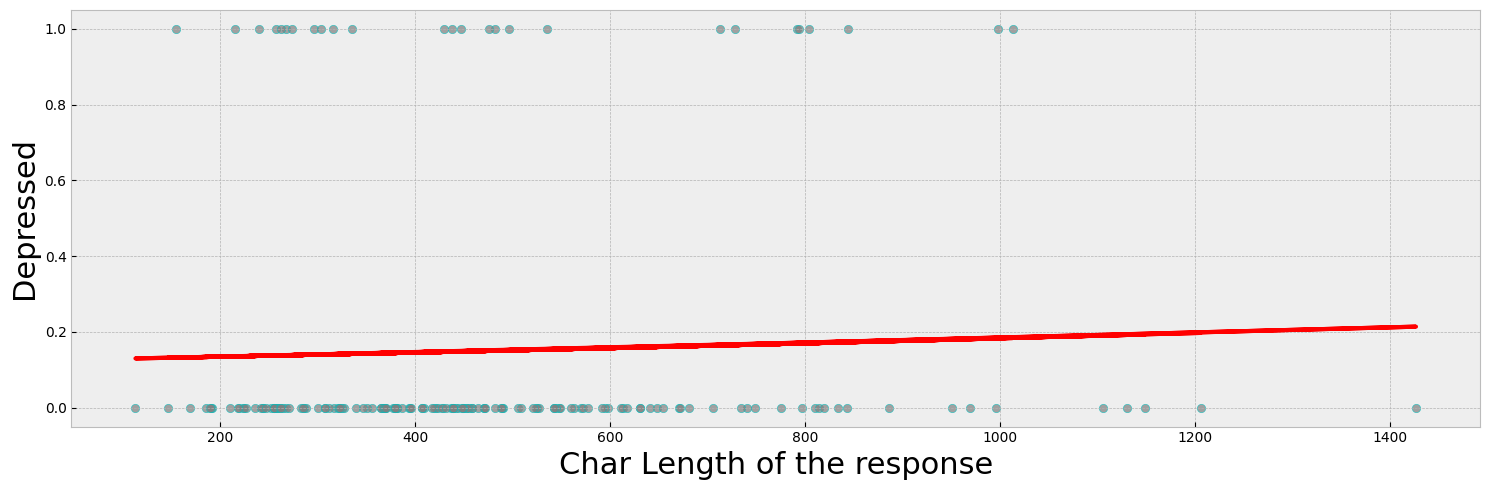

In [18]:
# let's visualize
from scipy.special import expit
plt.style.use('default')
plt.style.use('bmh')

fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(X, y, edgecolor='c', facecolor='grey', alpha=0.7)
ax.set_ylabel('Depressed', fontsize=22)
ax.set_xlabel('Char Length of the response', fontsize=22)
loss = expit(X * clf.coef_ + clf.intercept_).ravel()
plt.plot(X, loss, color='red', linewidth=3)
# ax.legend(facecolor='white', fontsize=18)
#ax.text(0.745, 0.25, '$y = %.2f x_1 - %.2f $' % (model.coef_[0], abs(model.intercept_)), fontsize=22, transform=ax.transAxes, color='#8B0000')
#ax.text(0.92, 0.045, '(c) Andrii Lunin', fontsize=13, ha='center', va='center', transform=ax.transAxes, color='grey', alpha=0.5)
# ax.set_title('$R^2= %.3f$' % model.score(X, y), fontsize=24)
fig.tight_layout()

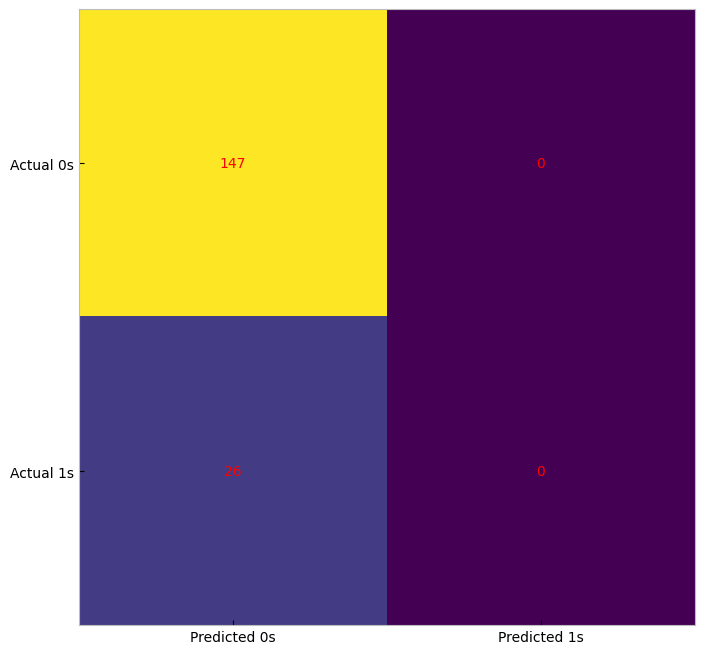

In [21]:
cm = confusion_matrix(y, clf.predict(X))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

As we can now see, all of the depressed people were misclassified, and hence **Logistic Model of the Character Counts** is a **not an appropriate model** for this case.

## II. Adjective count approach - X

### Setup

In [22]:
# reset the df to drop unnecessary columns 
df_analysis = df_analysis[["Transcription","depressed"]]

In [23]:
df_analysis

,Transcription,depressed
0,"Yeah, I think there's a beach, uh there are a ...",False
1,There are a bunch of people and creatures out ...,False
2,This is a very interesting picture of a beach ...,False
3,"This is a very fun, sunny, beach day. Everyone...",False
4,The image is an image of a beach. There're a l...,False
...,...,...
168,This is a very happy scene of a very diverse a...,False
169,People are having fun at the beach. Some peopl...,False
170,This is a beach photo. It's really cartoony an...,False
171,"Well, this is quite an interesting beach scene...",False


In [43]:
import spacy
!pip install spacytextblob
from spacytextblob.spacytextblob import SpacyTextBlob
nlp = spacy.load("en_core_web_sm") # XXX intall large dict
spacy_text_blob = SpacyTextBlob()
nlp.add_pipe(spacy_text_blob)

/usr/local/lib/python3.7/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [25]:
def count_adj(raw_text):
  doc = nlp(raw_text)

  cnt = 0
  for token in doc: 
    part_of_speech = token.pos_
    if part_of_speech in ["ADJ", "ADV"]:

      cnt += 1

  return cnt

In [26]:
df_analysis["num_adj"] = df_analysis[["Transcription"]].applymap(lambda x: count_adj(x) )


In [27]:
df_analysis

,Transcription,depressed,num_adj
0,"Yeah, I think there's a beach, uh there are a ...",False,9
1,There are a bunch of people and creatures out ...,False,7
2,This is a very interesting picture of a beach ...,False,8
3,"This is a very fun, sunny, beach day. Everyone...",False,9
4,The image is an image of a beach. There're a l...,False,0
...,...,...,...
168,This is a very happy scene of a very diverse a...,False,14
169,People are having fun at the beach. Some peopl...,False,8
170,This is a beach photo. It's really cartoony an...,False,11
171,"Well, this is quite an interesting beach scene...",False,16


### Model

In [28]:
num_adj = ['num_adj']
depressed = 'depressed'
# Just setup for the plot
X = df_analysis["num_adj"].values.reshape(-1, len(num_adj))
y = df_analysis["depressed"].values
clf = LogisticRegression(C=1e5)
clf.fit(X, y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Visualization

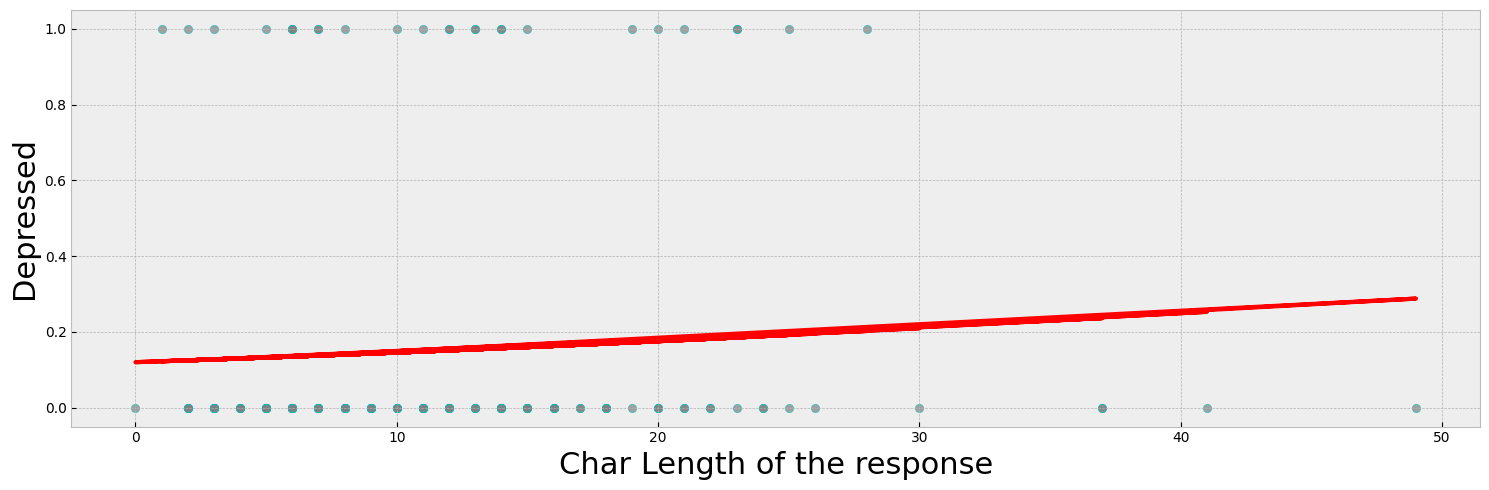

In [29]:
# let's visualize
plt.style.use('default')
plt.style.use('bmh')

fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(X, y, edgecolor='c', facecolor='grey', alpha=0.7)
ax.set_ylabel('Depressed', fontsize=22)
ax.set_xlabel('Char Length of the response', fontsize=22)
loss = expit(X * clf.coef_ + clf.intercept_).ravel()
plt.plot(X, loss, color='red', linewidth=3)
fig.tight_layout()

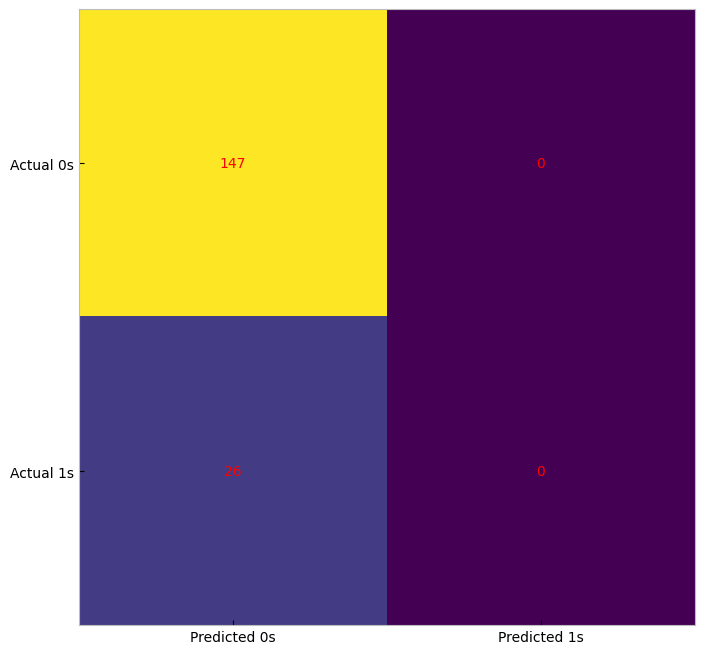

In [31]:
cm = confusion_matrix(y, clf.predict(X))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

## III. SpaCy polarity approach - X

https://spacy.io/universe/project/spacy-textblob





In [36]:
def polarity(raw_text):
  doc = nlp(raw_text)
  return doc._.sentiment.polarity

In [37]:
df_analysis["sentiment"] = df_analysis[["Transcription"]].applymap(lambda x: polarity(x) )

In [38]:
df_analysis

,Transcription,depressed,num_adj,sentiment
0,"Yeah, I think there's a beach, uh there are a ...",False,9,-0.037500
1,There are a bunch of people and creatures out ...,False,7,0.520000
2,This is a very interesting picture of a beach ...,False,8,0.337500
3,"This is a very fun, sunny, beach day. Everyone...",False,9,0.380000
4,The image is an image of a beach. There're a l...,False,0,0.300000
...,...,...,...,...
168,This is a very happy scene of a very diverse a...,False,14,0.241975
169,People are having fun at the beach. Some peopl...,False,8,0.566000
170,This is a beach photo. It's really cartoony an...,False,11,0.372159
171,"Well, this is quite an interesting beach scene...",False,16,0.030864


### Model

In [39]:
sentiment = ['sentiment']
depressed = 'depressed'
# Just setup for the plot
X = df_analysis["sentiment"].values.reshape(-1, len(sentiment))
y = df_analysis["depressed"].values
clf = LogisticRegression(C=1e5)
clf.fit(X, y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

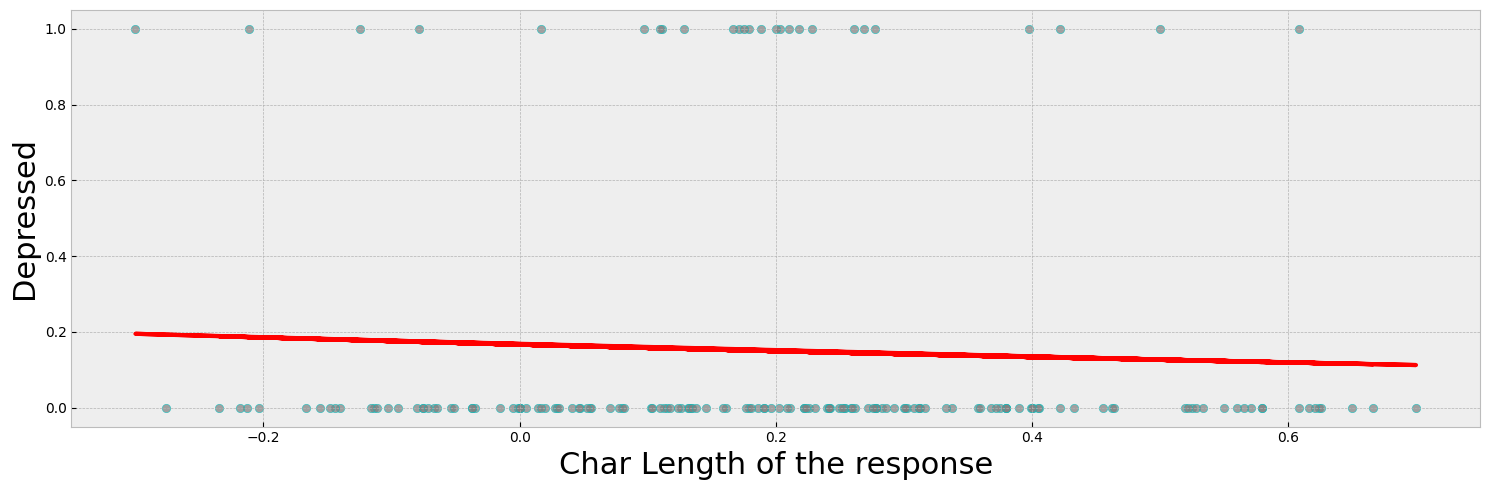

In [40]:
plt.style.use('default')
plt.style.use('bmh')

fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(X, y, edgecolor='c', facecolor='grey', alpha=0.7)
ax.set_ylabel('Depressed', fontsize=22)
ax.set_xlabel('Char Length of the response', fontsize=22)
loss = expit(X * clf.coef_ + clf.intercept_).ravel()
plt.plot(X, loss, color='red', linewidth=3)
fig.tight_layout()

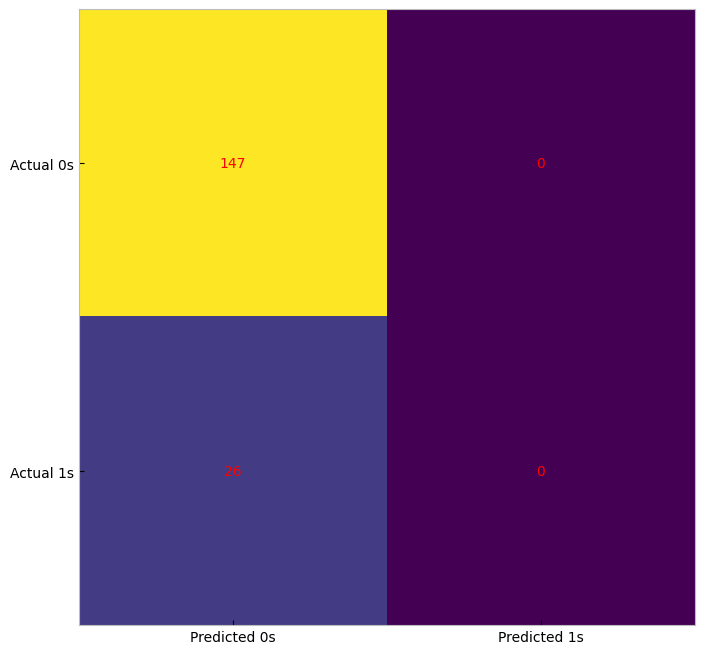

In [41]:
cm = confusion_matrix(y, clf.predict(X))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

## IV. Word vector with word2vec

In [45]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 782.7MB 1.3MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.3.1-cp37-none-any.whl size=782936123 sha256=31c89f353c91353a1ff5988fed7f224a8da3b98693cd630c6f2710dce7f44cd5
  Stored in directory: /tmp/pip-ephem-wheel-cache-4sr2_5jw/wheels/ce/4d/1b/bc6cabb6df139c5f0318927be3ae9e51363fb44d6ea328d3f4
Successfully built en-core-web-lg
  Found existing installation: en-core-web-lg 2.2.5
    Uninstalling en-core-web-lg-2.2.5:
      Successfully uninstalled en-core-web-lg-2.2.5
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


Compare evry two pairs of depressed and non depressed subjects

In [46]:
depressed_sbj = df_analysis[df_analysis["depressed"]]

In [51]:
happy_sbj = df_analysis[df_analysis["depressed"] != True]

In [53]:
nlp = spacy.load("en_core_web_lg")

In [56]:
transcribed_text = df_analysis["Transcription"].tolist()

In [ ]:
# comapre the average similarity
avg_depressed = []
avg_happy = []
overall_avg = []

for i in range(len(transcribed_text)):
  for j in range(i,len(transcribed_text)):
    doc1 = nlp(transcribed_text[i])
    doc2 = nlp(transcribed_text[j])
    overall_avg.append(doc1.similarity(doc2))

In [65]:
%%shell
jupyter nbconvert --to html /NLP_analysis.ipynb

[NbConvertApp] WARNING | pattern u'/NLP_analysis.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--inplace
    Run

CalledProcessError: ignored